# Classification of Textual Data

In [ ]:
import sys
import numpy as np
import pandas as pd
import scipy
%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import preprocessing
from IPython.core.debugger import set_trace
import warnings
warnings.filterwarnings('ignore')

np.random.seed(1234)

#### Utilities

In [ ]:
def logistic(z):
    '''Computes element-wise logistic for input vector z'''
    return 1./ (1 + np.exp(-z))

def cost_fn(x, y, w):
    '''Computes mean Cross Entropy as cost for Logistic Classifier'''
    N, D = x.shape                                                       
    z = np.dot(x, w)
    J = np.mean(y * np.log1p(np.exp(-z)) + (1-y) * np.log1p(np.exp(z)))  #log1p calculates log(1+x) to remove floating point inaccuracies 
    return J

In [ ]:
# KNN benchmarking
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from pprint import pprint

def get_knn(X_train, y_train, X_eval, y_eval):
  k_to_test = range(1, 10)
  benchmark = {}
  for k in k_to_test:
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train, y_train)
    y_pred_eval = model.predict(X_eval)
    accuracy = accuracy_score(y_pred_eval, y_eval)
    benchmark[k] = accuracy
  pprint(benchmark)

  best_k = max(benchmark, key=benchmark.get)
  print("Best K:", best_k, "with acc:", benchmark.get(best_k))
  return best_k

In [ ]:
# Multi label accuracy evaluation
def evaluate(y, y_pred):
    accuracy = sum(y_pred.argmax(axis=1) == y.argmax(axis=1))
    accuracy = accuracy / y.shape[0]
    return accuracy

In [ ]:
def plot_word_scores(words_df, title, score_label='Z score'):
    '''
    Plots a horizontal barplot for a dataframe with words and scores columns
    '''
    words = list(words_df['word'])
    scores = list(words_df['score'])
    plt.clf()
    
    y_pos = np.arange(len(words))
    fig, ax = plt.subplots()

    hbars = ax.barh(y_pos, scores, align='center')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(words)
    ax.invert_yaxis() # labels read top to bottom
    ax.set_xlabel(score_label)
    ax.set_title(title)
    plt.savefig(title, bbox_inches="tight", dpi=300)
    plt.show()

# 1. Data preprocessing (IMDB)
**Required Files Warning:** the following code expects the files `test_labeledBow.feat`, `train_labeledBow.feat` and `imdb.vocab` to be in the Files Menu. Please drag the required files and rename the file names as indicated above.


This section prepares the IMDB dataset for logistic regression by performing feature selection of 500 most correlated words and relabeling the response variable into binary labels. The results are stored in `imdb_train_X` and `imdb_train_y`.

In [ ]:
## IF USING GOOGLE -- NO WRITE PRIVILEGES
# from google.colab import drive
# drive.mount('/gdrive')
# %cd /gdrive
# File paths:
# # ./MyDrive/datasets/imdb/train_labeledBow.feat
# # ./MyDrive/datasets/imdb/test_labeledBow.feat
# # ./MyDrive/datasets/imdb/imdb.vocab

### Load imdb Train data

In [ ]:
# Use load_svmlight_file to read the libsvm files
from sklearn.datasets import load_svmlight_file
imdb_train_file = 'train_labeledBow.feat'

# X is a scipy.sparse.csr_matrix type, y is a list of target values (movie ratings)
imdb_train_X, imdb_train_y = load_svmlight_file(imdb_train_file, multilabel=True)

# Read in the list of vocabulary words
imdb_vocab_file = 'imdb.vocab'
full_vocabulary = pd.read_csv(imdb_vocab_file, header=None)
full_vocabulary

,0
0,the
1,and
2,a
3,of
4,to
...,...
89522,copywrite
89523,artbox
89524,kinky-sex
89525,urrrghhh


[12500 12500]
[0 1]


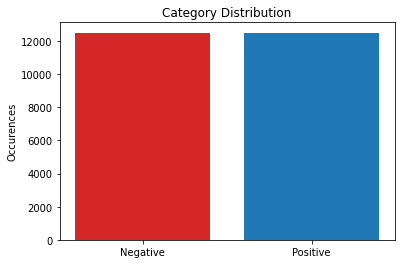

In [ ]:
# Class distribution
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

pos_neg_label = np.where(np.array(imdb_train_y).squeeze() > 5, 1, 0)

label_names = {
    0: 'Negative',
    1: 'Positive',
}

unique, counts = np.unique(pos_neg_label, return_counts=True)
print(counts)
print(unique)

bar_colors = ['tab:red', 'tab:blue']

ax.bar([label_names[x] for x in unique], counts, color=bar_colors)

ax.set_ylabel('Occurences')
ax.set_title('Category Distribution')

plt.show()


### 1.1 Feature Selection


In [ ]:
# Examine the shapes of our data
train_shape = imdb_train_X.get_shape()
print(f"Train set size N = {train_shape[0]}")
print(f"# of words in vocabulary = {train_shape[1]}")

Train set size N = 25000
# of words in vocabulary = 89527


#### Filtering out stopwords and rare words
We remove uncommon or "rare" words that appear in less than 1% of the documents and  stopwords appear in more than 50% of the documents. We will only count from the **training set** of the documents.

In [ ]:
import time

N_DOCUMENTS = imdb_train_X.shape[0]
N_FEATURES = imdb_train_X.shape[1]

# Keep the indexes of words that are not stopwords or uncommon
good_words = []
min_count = round(N_DOCUMENTS*0.01)
max_count = round(N_DOCUMENTS*0.50)
print("Min document appearances", min_count)
print("Max document appearances", max_count)

# Convert to CSC sparse matrix for efficient column slicing
imdb_train_X_CSC = imdb_train_X.tocsc() # Linear complexity. Specifically O(nnz(A) + max(n_row,n_col))

print(f"Filtering for {N_FEATURES} words...")
tic = time.perf_counter()
for word_id in range(N_FEATURES):
    word_column = imdb_train_X_CSC.getcol(word_id)
    n_docs = word_column.getnnz()
    if min_count < n_docs < max_count:
        good_words.append(word_id)

toc = time.perf_counter()
print(f"[Filtered features in {toc - tic:0.4f} seconds]")
print("Surviving features:", len(good_words))

Min document appearances 250
Max document appearances 12500
Filtering for 89527 words...
[Filtered features in 7.2900 seconds]
Surviving features: 1734


In [ ]:
# Filter vocabulary using the good_words array
filter_vocabulary = full_vocabulary.iloc[good_words]
filter_vocabulary.reset_index(inplace=True)    # reset to 0,1,2... but keep original word id

first_word_col = (imdb_train_X_CSC.getcol(good_words[0]).toarray())
last_word_col = (imdb_train_X_CSC.getcol(good_words[-1]).toarray())

# Filter data using the good_words array
filter_imdb_train_X = (imdb_train_X_CSC[:, good_words]).tocsr()

# Quick sanity check
first_word_col_filtered = (filter_imdb_train_X.getcol(0).toarray())
last_word_col_filtered = (filter_imdb_train_X.getcol(filter_imdb_train_X.shape[1]-1).toarray())

print("Filtered dataset shape (documents, words):", filter_imdb_train_X.get_shape())

print("---")
print("Testing correctness of column-word correspondence after index reset:")
if (np.all(first_word_col == first_word_col_filtered) and \
    np.all(last_word_col == last_word_col_filtered)):
    print("PASSED")
else:
    print("FAILED")
print("---")

# Cleanup
del full_vocabulary
del imdb_train_X_CSC

filter_vocabulary

Filtered dataset shape (documents, words): (25000, 1734)
---
Testing correctness of column-word correspondence after index reset:
PASSED
---


,index,0
0,21,he
1,23,his
2,27,!
3,30,by
4,31,an
...,...,...
1729,1924,portray
1730,1929,discovered
1731,1933,aware
1732,1935,continues


#### Feature selection based on Z-score

In [ ]:
# Our target variable has values 1, 2, 3, 4 or 7, 8, 9, 10 
# To get negative and positive correlation values, use a transformed version of y to compute z scores, 
# where the ratings are mapped to a negative or positive scale from 1-5.

y = np.array(imdb_train_y)
print("Before transforming y")
print(y[:5])
y = np.where(y < 5, -y, y-6)
print("After transforming y")
print(y[:5])

Before transforming y
[[ 9.]
 [ 7.]
 [ 9.]
 [10.]
 [ 8.]]
After transforming y
[[3.]
 [1.]
 [3.]
 [4.]
 [2.]]


In [ ]:
# Compute the z-score for each feature column with respect to the target variable y.
# We can get z scores with matrix multiplication X'y and then dividing all elements by sqrt(N),
# Warning: running the cell several times may drain all of our available RAM in Colaboratory.

import math
N = filter_imdb_train_X.shape[0]
X = filter_imdb_train_X.toarray()    # ndarray
y = np.array(y)                      # ndarray

# Z scores is a numpy matrix (indexed 0...D-1)
Z_scores = np.matmul(X.T, y) 
Z_scores /= math.sqrt(N)             # ndarray

print("Z-score matrix shape:", Z_scores.shape)

# Goal: keep the D = 250 features with largest Z-score magnitude
abs_Z_scores = abs(Z_scores)
top_zscore_indexes = np.argsort(abs_Z_scores[:,0])      # ndarray
D = 250
top_zscore_indexes = top_zscore_indexes[::-1][:D]

# Get Top Words and their top Z Scores into a dataframe
top_words_df = filter_vocabulary.iloc[top_zscore_indexes]     # dataframe
top_words_df.reset_index(inplace=True, drop=True)             # drop indexes from z score matrix
top_scores_df = pd.DataFrame(Z_scores[top_zscore_indexes])    # ndarray

words_scores_df = pd.concat([top_words_df, top_scores_df], axis=1)
words_scores_df.columns = ["index", "word", "score"]

# Column descriptions
# index: word id from original imbd.vocab file
# word: the string contained in the review
# score: the z-score of the word count with respect to rating
words_scores_df

Z-score matrix shape: (1734, 1)


,index,word,score
0,23,his,86.570513
1,27,!,78.784986
2,83,great,71.492773
3,46,?,-68.868083
4,77,bad,-62.145081
...,...,...,...
245,385,often,5.723723
246,485,game,5.692100
247,383,others,5.692100
248,662,jack,5.666802


### Examine Negatively and Positively correlated words

In [ ]:
# Add a new column to classify whether a word is negative or positive
words_scores_df['sentiment'] = words_scores_df['score'] > 0

In [ ]:
# Examine top 10 positive words
positive_words = words_scores_df[words_scores_df['sentiment']==True].sort_values('score', ascending=False)
print("# of positively correlated words =", positive_words.shape[0])
positive_words[['word', 'score']].head(10)

# of positively correlated words = 174


,word,score
0,his,86.570513
1,!,78.784986
2,great,71.492773
5,he,58.976478
6,best,46.181903
7,my,46.112333
8,very,45.815079
9,love,44.550168
10,has,40.483479
11,who,40.205198


In [ ]:
# Examine top 10 negative words
negative_words = words_scores_df[words_scores_df['sentiment']!=True].sort_values('score', ascending=True)
print("# of negatively correlated words =", negative_words.shape[0])
negative_words[['word', 'score']].head(10)

# of negatively correlated words = 76


,word,score
3,?,-68.868083
4,bad,-62.145081
19,no,-32.210960
24,just,-28.460499
25,there,-26.379720
35,worst,-21.952532
42,nothing,-20.681296
43,plot,-20.649673
49,even,-18.568894
52,or,-17.512694


#### Most Positive and Negative Words

Report the top 10 features with the most positive z-scores and the top 10 features with
the most negative z-scores on the IMDB data using simple linear regression on the movie
rating scores.

**Note:** `words_scores_df` is a DataFrame generated in Task 1. If undefined, please run Task 1 first.

Number of positively correlated words 174


<Figure size 432x288 with 0 Axes>

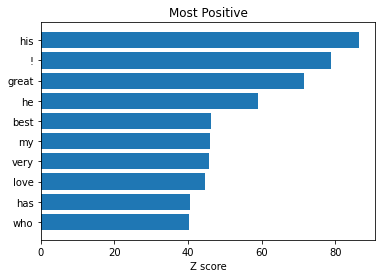

In [ ]:
# Examine top 10 positive words
positive_words = words_scores_df[words_scores_df['sentiment']==True].sort_values('score', ascending=False)
print("Number of positively correlated words", positive_words.shape[0])
plot_word_scores(positive_words[['word', 'score']].head(10), 'Most Positive')

Number of negatively correlated words 76


<Figure size 432x288 with 0 Axes>

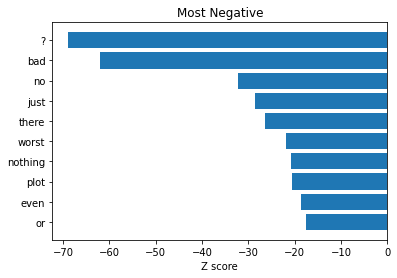

In [ ]:
# Examine top 10 negative words
negative_words = words_scores_df[words_scores_df['sentiment']!=True].sort_values('score', ascending=True)
print("Number of negatively correlated words", negative_words.shape[0])
plot_word_scores(negative_words[['word', 'score']].head(10), 'Most Negative')

These top features with the most positive and most negative z-scores can be used for calliing a movie good or bad respectively. 


### Preprocessing results

In [ ]:
# Get the list selected words vocab ids
selected_word_indexes = list(words_scores_df['index'])

imdb_train_X = (imdb_train_X.tocsc()[:, selected_word_indexes]).tocsr()

# Relabel the data set with binary class; 0 for negative and 1 for positive
imdb_train_y = np.where(np.array(imdb_train_y) > 5, 1, 0)

In [ ]:
imdb_train_y.shape, imdb_train_X.shape

((25000, 1), (25000, 250))

#Data Preprocessing (20 news groups)

## Load 20 News Groups Train Data

In [ ]:
import numpy as np
import re
import string
import matplotlib.pyplot as plt


In [ ]:
from sklearn.datasets import fetch_20newsgroups
train_dataset = fetch_20newsgroups(subset='train', categories=['comp.graphics', 'rec.sport.hockey', 'sci.med', 'soc.religion.christian'], remove=(['headers', 'footers', 'quotes']))
test_dataset = fetch_20newsgroups(subset='test', categories=['comp.graphics', 'rec.sport.hockey', 'sci.med', 'soc.religion.christian'], remove=(['headers', 'footers', 'quotes']))

[584 600 594 599]
['comp.graphics', 'rec.sport.hockey', 'sci.med', 'soc.religion.christian']


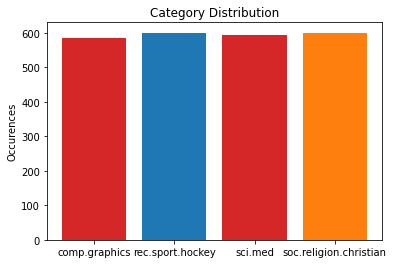

In [ ]:
# Class distribution

import matplotlib.pyplot as plt

fig, ax = plt.subplots()

unique, counts = np.unique(train_dataset.target, return_counts=True)
print(counts)
print(train_dataset.target_names)

bar_colors = ['tab:red', 'tab:blue', 'tab:red', 'tab:orange']

ax.bar(train_dataset.target_names, counts, color=bar_colors)

ax.set_ylabel('Occurences')
ax.set_title('Category Distribution')

plt.show()

##Feature Selection using mutual information

In [ ]:
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import mutual_info_score
from collections import defaultdict

In [ ]:
from pprint import pprint
def getBagWords(dataset, num_top_features):
  normal_vectorizer = CountVectorizer()
  normal_bag = normal_vectorizer.fit_transform(dataset.data)
  standardized_words = []
  min_count = 0.01 * normal_bag.shape[0]
  max_count = 0.50 * normal_bag.shape[0] 
  for word_id in range(len(normal_vectorizer.get_feature_names_out())): #iterate through all 30945 words
    word_column = normal_bag.getcol(word_id) #locate the column of the current word in the sparse matrix
    n_docs = word_column.getnnz() #number of documents that contain at least one occurance of the current word
    if min_count < n_docs < max_count:
        standardized_words.append(word_id)
  standardized_vocab = normal_vectorizer.get_feature_names_out()[standardized_words] #getting the feature names of the good words
  standardized_vectorizer = CountVectorizer(vocabulary=standardized_vocab)
  standardized_bag = standardized_vectorizer.fit_transform(dataset.data) #a new sparse matrix containing columns of good words
  standardized_bag.shape #feature size reduced from 30945 to 1586
  train_label_one_hot = LabelBinarizer().fit_transform(dataset.target)

  category_feature_words = defaultdict(list)
  feature_words = []
  for category in range(train_label_one_hot.shape[1]): #4 total categories
    mi_scores = mutual_info_classif(standardized_bag, train_label_one_hot[:, category]) #returns an array of the mi scores of each feature for the label at this iteration
    sorted_index_array = np.argsort(mi_scores) #returns index of words sorted from least to most by their mi score
    sorted_index_array = sorted_index_array[-num_top_features:] #get the index of 10 words that contain the most mutual information with the label
    top_10_features = standardized_vectorizer.get_feature_names_out()[sorted_index_array]
    category_feature_words[dataset.target_names[category]] = top_10_features #getting the feature names of the top 10 words and store it with the label
    feature_words.append(top_10_features) #add the top 10 features to the total selected feature pool
  print("Most important words per category:")
  pprint(dict(category_feature_words))
  return feature_words

# 2. Model Implementation

### Logistic Regression

In [ ]:
class LogisticRegression:
    '''
    Logistic regression for binary classification tasks.
    Set hyperparameters on creation.
    '''
    def __init__(self, add_bias=True, learning_rate=.1, epsilon=1e-4, max_iters=1e4, verbose=False):
        self.add_bias = add_bias
        self.learning_rate = learning_rate            # also known as Step Size
        self.epsilon = epsilon                        # stopping condition: tolerance for gradient norm
        self.max_iters = max_iters                    # stopping condition: max iterations of G Descent
        self.verbose = verbose

    def gradient(self, X, y):
        '''
        X is a dense np.array with shape (N,D)
        y is a np.array with shape (N,)
        '''
        N, D = X.shape
        
        pred_y = logistic(np.dot(X, self.w))
        d =  pred_y - y
        
        # divide gradient by N since our cost func = 1/N * CE
        grad = np.dot(X.T, d) / N  
        return grad

    def ce(self, x, y):
        # Numerically precise cross-entropy
        N, D = x.shape                                       
        z = np.dot(x, self.w)
        J = np.mean(y * np.log1p(np.exp(-z)) + (1-y) * np.log1p(np.exp(z)))  #log1p calculates log(1+x) to remove floating point inaccuracies 
        return J

    def fit(self, x, y, monitor_CE=False):
        if x.ndim == 1:
            x = x[:, None] # essentially [x] -> [[x]]

        if self.add_bias:
            N = x.shape[0]
            x = np.column_stack([x, np.ones(N)])   # add column vector 1 for the bias

        N, D = x.shape
        self.w = np.zeros(D)                      # initialize all weights to 0
        g = np.inf                                # start with a large gradient
        t = 0

        ce_all = np.zeros(int(self.max_iters))

        # Gradient Descent
        while np.linalg.norm(g) > self.epsilon and t < self.max_iters:
            # Stop when the gradient's norm is sufficiently small
            g = self.gradient(x, y)
            self.w = self.w - self.learning_rate * g

            if (monitor_CE):
                ce_all[t] = self.ce(x, y)    

            t += 1

        if self.verbose:
            print(f'terminated after {t} iterations, with norm of the gradient equal to {np.linalg.norm(g)}')
            # print(f'the weight found: {self.w}')
        return ce_all[:t]
    
    def predict(self, x):
        if x.ndim == 1:
            x = x[:, None]
        Nt = x.shape[0]
        if self.add_bias:
            x = np.column_stack([x,np.ones(Nt)])
        y_pred = logistic(np.dot(x,self.w))
        return y_pred

    def check_grad(self, X, y):
        # Code adapted from the Multinomial_logistic class
        if self.add_bias:
            N = X.shape[0]
            X = np.column_stack([X, np.ones(N)])   # add column vector 1 for the bias
    
        N = y.shape[0]
        D = X.shape[1]

        diff = np.zeros(D)

        w = self.w.copy()

        # For every w_d, compute difference between estimated and analytical gradient
        for i in range(D):
            epsilon = np.zeros(D)
            epsilon[i] = np.random.rand() * 1e-5
            self.w = self.w + epsilon
            J1 = self.ce(X, y)
            self.w = w
            self.w = self.w - epsilon
            J2 = self.ce(X, y)
            self.w = w
            numeric_grad = (J1 - J2) / (2 * epsilon[i])
            derived_grad = self.gradient(X, y)[i]

            diff[i] = np.square(derived_grad - numeric_grad).sum() / \
                            np.square(derived_grad + numeric_grad).sum()

        return diff.sum()

### Multi-class Regression

In [ ]:
class Multinomial_logistic:
    '''
    Logistic regression for multiple classification tasks.
    Set hyperparameters on fit invocation.

    Defines methods for fitting, predicting, 
    '''
    def __init__(self, nFeatures, nClasses):
        # Weights is now a matrix DxC
        self.W = np.random.rand(nFeatures, nClasses)

    def predict(self, X):
        # Return a matrix NxC of probabilities
        # Use softmax for every class
        y_pred = np.exp(np.matmul(X, self.W))
        return y_pred / y_pred.sum(axis=1).reshape(X.shape[0], 1)

    def grad(self, X, y):
        # Return a matrix DxC,
        # where columns are gradient vectors for each class
        return np.matmul(X.transpose(), self.predict(X) - y) # DxN x NxC

    def ce(self, X, y):
        return -np.sum(y * np.log(self.predict(X)))


    def fit(self, X, y, X_valid=None, y_valid=None, lr=0.001, niter=100, threshold=1e-4, early_stop=False, loss_output=False):
        losses_train = np.zeros(niter)
        losses_valid = np.zeros(niter)

        def smallImprovement(prevLoss, currLoss):
            return abs(prevLoss - currLoss) < threshold

        for i in range(niter):
            self.W = self.W - lr * self.grad(X, y)         # update coefficients W
            loss_train = self.ce(X, y)                     # compute new loss
            losses_train[i] = loss_train                   # keep track of decrease

            if (early_stop and i > 1 and smallImprovement(losses_train[i-1], loss_train)):  
                # early stop if cost does not improve by a min threshold
                print(f"Early stop after {i+1} interations. CE = {loss_train}")
                break
            
            if X_valid is not None and y_valid is not None:
                loss_valid = self.ce(X_valid, y_valid)
                losses_valid[i] = loss_valid
                if (early_stop and i > i and losses_valid[i] > losses_valid[i-1]):
                  # breaking condition which indicates overfitting
                  print(f"Early stop since {losses_valid[i]} > {losses_valid[i-1]} after {i+1} iterations as the validation error increases")
                  break
                if loss_output:
                  print(f"iter {i}: {loss_train:.3f}; {loss_valid:.3f}")
            else:
                if loss_output:
                  print(f"iter {i}: {loss_train:.3f}")
        
        t = i + 1
        if t < niter:
            return losses_train[:t], losses_valid[:t]

        return losses_train, losses_valid

    def check_grad(self, X, y):
        # Small perturbation
        N, C = y.shape
        D = X.shape[1]

        diff = np.zeros((D, C))

        W = self.W.copy()

        for i in range(D):
            for j in range(C):
                epsilon = np.zeros((D, C))
                epsilon[i, j] = np.random.rand() * 1e-4

                self.W = self.W + epsilon
                J1 = self.ce(X, y)
                self.W = W

                self.W = self.W - epsilon
                J2 = self.ce(X, y)
                self.W = W

                numeric_grad = (J1 - J2) / (2 * epsilon[i, j])
                derived_grad = self.grad(X, y)[i, j]

                diff[i, j] = np.square(derived_grad - numeric_grad).sum() / \
                             np.square(derived_grad + numeric_grad).sum()

        return diff.sum()


# 3. Running Experiments 

## Binary Classification on IMDB reviews

We compute predictions based on the 500 words selected and stored in the `selected_word_indexes` array from task 1.1 (contains the word id's from `imdb.vocab` that are most correlated to the target variable y).

### Training the model

In [ ]:
# Load Test Data
imdb_test_file = 'train_labeledBow.feat'
imdb_test_X, imdb_test_y = load_svmlight_file(imdb_test_file, multilabel=True)

# Test data, subselected features according to Task 1.1 and binary labeling
imdb_test_X = (imdb_test_X.tocsc()[:, selected_word_indexes]).tocsr()
imdb_test_y = np.where(np.array(imdb_test_y) > 5, 1, 0) # 0 for bad reviews, 1 for good reviews 

# Prepare all data into dense np.ndarray form
if isinstance(imdb_train_X, scipy.sparse.csr.csr_matrix):
    imdb_train_X = imdb_train_X.toarray()

if isinstance(imdb_test_X, scipy.sparse.csr.csr_matrix):
    imdb_test_X = imdb_test_X.toarray()

# Fix shapes of our y vectors
imdb_train_y = imdb_train_y.squeeze()
imdb_test_y = imdb_test_y.squeeze()

In [ ]:
model = LogisticRegression(add_bias=True, learning_rate=.1, epsilon=1e-4, max_iters=1e4, verbose=True)

# Use np.arrays, dense, not matrices.
tic = time.perf_counter()

ce_all = model.fit(np.array(imdb_train_X), imdb_train_y, monitor_CE=True)

toc = time.perf_counter()
print(f"[Trained Logistic Regression in {toc - tic:0.4f} seconds]")

terminated after 10000 iterations, with norm of the gradient equal to 0.0009227681241744485
[Trained Logistic Regression in 176.5910 seconds]


### Checking the Gradient

Training error achieved: 0.35588909625773174


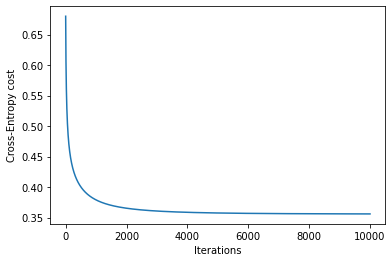

In [ ]:
# Plot Training Error decrease
print("Training error achieved:", ce_all[-1])
plt.plot(range(len(ce_all)), ce_all)
plt.ylabel("Cross-Entropy cost")
plt.xlabel("Iterations")
plt.savefig("LR_monitor_CE", bbox_inches="tight", dpi=300)

In [ ]:
# Check gradient
small_perturb =  model.check_grad(imdb_train_X, imdb_train_y)
print("Small perturbation results:", "{:.2e}".format(small_perturb))

Small perturbation results: 6.06e-07


### Accuracy of Logistic Regression 

In [ ]:
pred_y = model.predict(imdb_test_X) # probability estimates
pred_y_label = np.where(pred_y>0.5, 1, 0)
acc = np.mean(pred_y_label == imdb_test_y)

print("Accuracy on the test set:", "{0:.3f}%".format(acc*100))

Accuracy on the test set: 84.908%


### Logistic Regression vs K-Nearest Neighbors - ROC

In [ ]:
# Validation -- Find a suitable value of K for the KNN model
from sklearn.model_selection import train_test_split
train_knn_X, val_knn_X, train_knn_y, val_knn_y, = train_test_split(imdb_train_X, imdb_train_y, test_size=0.25, random_state=0)

print("Values of K -> Validation accuracy")
tic = time.perf_counter()
BEST_K = get_knn(X_train=train_knn_X, y_train=train_knn_y, X_eval=val_knn_X, y_eval=val_knn_y)
toc = time.perf_counter()
print(f"[Validated best k for K-NN in {toc - tic:0.4f} seconds]")

Values of K -> Validation accuracy
{1: 0.62608,
 2: 0.60928,
 3: 0.64992,
 4: 0.63472,
 5: 0.66368,
 6: 0.66192,
 7: 0.67184,
 8: 0.66656,
 9: 0.68064}
Best K: 9 with acc: 0.68064
[Validated best k for K-NN in 32.6725 seconds]


In [ ]:
# Get predictions with 1-NN for comparison
knn = KNeighborsClassifier(n_neighbors=BEST_K)
tic = time.perf_counter()
knn.fit(imdb_train_X, imdb_train_y)
toc = time.perf_counter()
print(f"[Trained {BEST_K}-NN in {toc - tic:0.4f} seconds]")
tic = time.perf_counter()
y_pred_knn = knn.predict_proba(imdb_test_X) # probability estimates
y_pred_knn = y_pred_knn[:,1] # 
toc = time.perf_counter()

print(f"[Predicted with {BEST_K}-NN in {toc - tic:0.4f} seconds]")

[Trained 9-NN in 0.0121 seconds]
[Predicted with 9-NN in 19.5205 seconds]


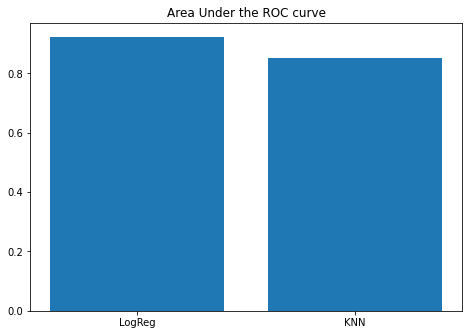

Logistic Regresion AUC score =  0.9238607871999999
KNN AUC score =  0.851708736


In [ ]:
# Compute ROC AUC score for Logistic Regression and KNN on IMDB
from sklearn.metrics import roc_auc_score

lr_auc_score = roc_auc_score(imdb_test_y, pred_y)
knn_auc_score = roc_auc_score(imdb_test_y, y_pred_knn)

import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
models = ['LogReg', 'KNN']
AUROC = [lr_auc_score, knn_auc_score]
ax.bar(models, AUROC)
ax.set_title("Area Under the ROC curve")
plt.show()


print("Logistic Regresion AUC score = ",lr_auc_score)   # 0.92
print("KNN AUC score = ", knn_auc_score)

#### Plot ROC Curves

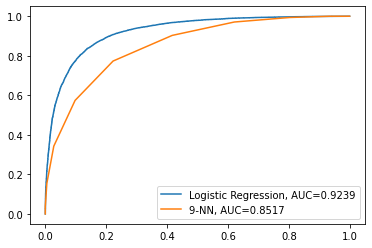

In [ ]:
from sklearn import metrics

#set up plotting area
plt.figure(0).clf()

#fit logistic regression model and plot ROC curve
y_pred_lr = pred_y # Logistic regression predictions
fpr, tpr, _ = metrics.roc_curve(imdb_test_y, y_pred_lr) # note shape
auc = round(metrics.roc_auc_score(imdb_test_y, y_pred_lr), 4)
plt.plot(fpr,tpr,label="Logistic Regression, AUC="+str(auc))

#fit KNN model and plot ROC curve

fpr, tpr, _ = metrics.roc_curve(imdb_test_y, y_pred_knn)
auc = round(metrics.roc_auc_score(imdb_test_y, y_pred_knn), 4)
plt.plot(fpr,tpr,label="9-NN, AUC="+str(auc))

#add legend
plt.legend()
plt.savefig("ROC_curves", bbox_inches="tight", dpi=300)

#### Accuracy and ROC as a function of Data set size

In [ ]:
accuracies_LR = []
accuracies_KNN = []
auroc_LR = []
auroc_KNN = []

SIZES =  [0.2, 0.4, 0.6, 0.8, 1]
N = imdb_train_X.shape[0]

# For different sizes of training set, record the accuracy on the held out test set
for train_size in SIZES:
    test_size = 1.0 - train_size
    print(f"--Models with N = {int(N*train_size)} observations")
    
    if train_size == 1.0:
        trainX = imdb_train_X
        trainY = imdb_train_y
    else:
        # Sub sample the training set
        trainX, _, trainY, _ = train_test_split(imdb_train_X, imdb_train_y, test_size=test_size, random_state=0)

    # Logistic regression
    LR_model = LogisticRegression(add_bias=True, learning_rate=.1, epsilon=1e-4, max_iters=1e4, verbose=False)
    LR_model.fit(trainX, trainY)
    lr_predY = LR_model.predict(imdb_test_X)
    lr_predY_label = np.where(lr_predY > 0.5, 1, 0)
    lr_accuracy = accuracy_score(lr_predY_label, imdb_test_y)
    lr_auroc = metrics.roc_auc_score(imdb_test_y, lr_predY)
    print("Done fitting LR")
    accuracies_LR.append(lr_accuracy)
    auroc_LR.append(lr_auroc)

    # KNN
    KNN_model = KNeighborsClassifier(n_neighbors=BEST_K)
    KNN_model.fit(trainX, trainY)
    knn_predY = (KNN_model.predict_proba(imdb_test_X))[:, 1]    # probability y=1
    knn_predY_label = np.where(knn_predY > 0.5, 1, 0)
    knn_accuracy = accuracy_score(knn_predY_label, imdb_test_y)
    knn_auroc = metrics.roc_auc_score(imdb_test_y, knn_predY)
    print("Done fitting KNN")
    accuracies_KNN.append(knn_accuracy)
    auroc_KNN.append(knn_auroc)


--Models with N = 5000 observations
Done fitting LR
Done fitting KNN
--Models with N = 10000 observations
Done fitting LR
Done fitting KNN
--Models with N = 15000 observations
Done fitting LR
Done fitting KNN
--Models with N = 20000 observations
Done fitting LR
Done fitting KNN
--Models with N = 25000 observations


In [ ]:
auroc_LR

In [ ]:
print("Now plotting Accuracy as a function of training set size")

# Plot Accuracy as function of training set size
plt.clf()

labels = ['20%', '40%', '60%', '80%', '100%']
x_axis = np.arange(len(labels))
bar_width = 0.30

fig, ax = plt.subplots()
plt.figure(figsize=(8,8))
lr_bars = ax.bar(x_axis - bar_width/2, accuracies_LR, bar_width, label='LogReg')
knn_bars = ax.bar(x_axis + bar_width/2, accuracies_KNN, bar_width, label='KNN')

# Text for labels, title and custom x-axis labels

ax.set_ylabel('Accuracy')
ax.set_title('Accuracy by model and data size')
ax.set_xticks(x_axis)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = round(rect.get_height(),3)
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(lr_bars)
autolabel(knn_bars)

fig.tight_layout()
plt.savefig("Accuracy_by_data_size_binary", bbox_inches="tight", dpi=300)
plt.show()

In [ ]:
print("Now plotting AUROC score as a function of training set size")

# Plot AUROC as function of training set size
plt.clf()

labels = ['20%', '40%', '60%', '80%', '100%']
x_axis = np.arange(len(labels))
bar_width = 0.35

fig, ax = plt.subplots()
plt.figure(figsize=(8,8))
lr_bars = ax.bar(x_axis - bar_width/2, auroc_LR, bar_width, label='LogReg')
knn_bars = ax.bar(x_axis + bar_width/2, auroc_KNN, bar_width, label='KNN')

# Text for labels, title and custom x-axis labels

ax.set_ylabel('AUROC')
ax.set_title('Scores by model and data size')
ax.set_xticks(x_axis)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = round(rect.get_height(),3)
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(lr_bars)
autolabel(knn_bars)

fig.tight_layout()
fig.savefig("AUROC_by_data_size", bbox_inches="tight", dpi=300)


### Most important words by coefficient

In [ ]:
model_no_bias = LogisticRegression(add_bias=False, learning_rate=.1, epsilon=1e-4, max_iters=1e4, verbose=True)
model_no_bias.fit(imdb_train_X, imdb_train_y)

word_weights =  model_no_bias.w
word_weights.shape

terminated after 10000 iterations, with norm of the gradient equal to 0.0009204703018967302


(250,)

In [ ]:
# Get indexes of strongest feature weights
sorted_word_weights = np.argsort(word_weights)
top_word_i_positive = sorted_word_weights[-10:]    # indexes
top_word_i_negative = sorted_word_weights[:10]    # indexes

In [ ]:
words_scores_df.iloc[top_word_i_positive]

,index,word,score,sentiment
230,922,unique,5.976705,True
238,1251,beautifully,5.831240,True
134,748,fantastic,9.872631,True
67,493,favorite,14.767837,True
34,369,wonderful,22.097996,True
103,529,highly,11.460094,True
51,459,amazing,17.759351,True
58,392,perfect,16.627256,True
144,870,superb,9.252824,True
30,309,excellent,23.432477,True


In [ ]:
words_scores_df.iloc[top_word_i_negative]

,index,word,score,sentiment
84,427,waste,-13.211996,False
35,240,worst,-21.952532,False
191,856,poorly,-7.134098,False
72,368,awful,-14.154355,False
162,734,dull,-8.500202,False
242,906,mess,-5.780644,False
164,598,annoying,-8.468580,False
148,503,horrible,-9.126333,False
68,344,boring,-14.647670,False
210,813,lame,-6.691380,False


<Figure size 432x288 with 0 Axes>

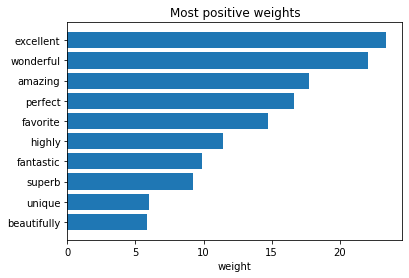

<Figure size 432x288 with 0 Axes>

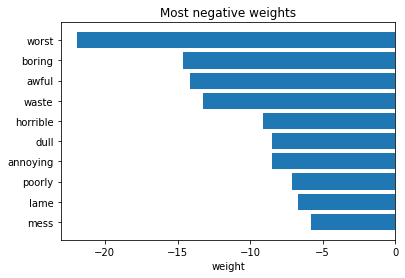

In [ ]:
plot_word_scores(words_scores_df.iloc[top_word_i_positive].sort_values('score', ascending=False), "Most positive weights", "weight")

plot_word_scores(words_scores_df.iloc[top_word_i_negative].sort_values('score'), "Most negative weights", "weight")

## Multiclass Classification on 20 News Groups

In [ ]:
#select most relevant features
feature_words = getBagWords(train_dataset, 10)
feature_words = np.array(feature_words).flatten()

Most important words per category:
{'comp.graphics': array(['program', 'god', '3d', 'image', 'his', 'file', 'files', 'who',
       'he', 'graphics'], dtype=object),
 'rec.sport.hockey': array(['teams', 'league', 'games', 'players', 'play', 'nhl', 'season',
       'hockey', 'game', 'team'], dtype=object),
 'sci.med': array(['surrender', 'intellect', 'dsl', 'cadre', 'shameful', 'n3jxp',
       'chastity', 'geb', 'gordon', 'banks'], dtype=object),
 'soc.religion.christian': array(['faith', 'not', 'we', 'christian', 'church', 'christians', 'bible',
       'christ', 'jesus', 'god'], dtype=object)}


In [ ]:
from sklearn import model_selection
feature_words = np.unique(feature_words) # must have unique features. for example, we had 'god' occuring in two categories 
feature_vectorizer = CountVectorizer(vocabulary=feature_words)
X_train_bag_of_words = feature_vectorizer.fit_transform(train_dataset.data) #sparse matrix of the 39 selected features
X_train_bag_of_words.shape

In [ ]:
#one-hot encode y_train
train_label_one_hot = LabelBinarizer().fit_transform(train_dataset.target)
#vectorize X_train
X_train_n = X_train_bag_of_words
X_train_n = X_train_n.toarray()
y_train_n = train_label_one_hot

# split train data set into training and validation
X_train_news, X_valid_news, y_train_news, y_valid_news = model_selection.train_test_split(X_train_n, y_train_n, test_size = 0.20, random_state=1, shuffle=True)
print(X_train_news.shape, X_valid_news.shape, y_train_news.shape, y_valid_news.shape)

###Training the model

In [ ]:
D = X_train_n.shape[1] #number of features
C = y_train_n.shape[1] #number of classes
D,C

In [ ]:
multiClass_model = Multinomial_logistic(D,C) 
#X_train_news = np.array(X_train_news, dtype = np.float128) #this solves the nan issue caused by float64
X_train_n = np.array(X_train_n, dtype = np.float128)
multiClass_model.W = np.array(multiClass_model.W, dtype = np.float128)

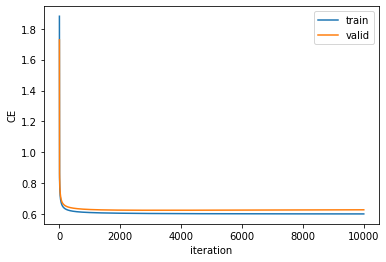

In [ ]:
ce_train, ce_valid = multiClass_model.fit(X_train_news, y_train_news, X_valid_news, y_valid_news, niter=10000, early_stop=True)
plt.clf()
plt.plot(ce_train/X_train_news.shape[0], label='train')
plt.plot(ce_valid/X_valid_news.shape[0], label='valid')
plt.xlabel("iteration")
plt.ylabel("CE")
plt.legend()

plt.savefig("training_ce.png", bbox_inches="tight", dpi=300)
plt.show()

###Checking the Gradient 

In [ ]:
multiClass_model.check_grad(X_train_n, y_train_n)

2.7810253673725844e-13

###Accuracy of Multiclass Logistic regression

In [ ]:
# training accuracy
train_accuracy = evaluate(multiClass_model.predict(X_train_n), y_train_n)
print(train_accuracy)

0.7517879680269247


In [ ]:
# convert testing data into a bag of words with only the featured words we found earlier
test_vectorizer = CountVectorizer(vocabulary=feature_words)
X_test_news = test_vectorizer.fit_transform(test_dataset.data)
X_test_news = X_test_news.toarray()
X_test_news = np.array(X_test_news, dtype = np.float128)
X_test_news.shape

(1582, 39)

In [ ]:
# one-hot encode y_test data
y_test_news = LabelBinarizer().fit_transform(test_dataset.target)
y_test_news.shape

(1582, 4)

In [ ]:
# evaluate test accuracy
test_accuracy = evaluate(multiClass_model.predict(X_test_news), y_test_news)
print(test_accuracy)

0.7123893805309734


### Accuracy of KNN

In [ ]:
## 20 news group 
get_knn(X_train_n, y_train_n, X_test_news, y_test_news)

{1: 0.6144121365360303,
 2: 0.5176991150442478,
 3: 0.6219974715549936,
 4: 0.488621997471555,
 5: 0.5448798988621998,
 6: 0.49620733249051835,
 7: 0.5316055625790139,
 8: 0.4974715549936789,
 9: 0.5189633375474083}
Best K: 3 with acc: 0.6219974715549936


3

### Convergence graph

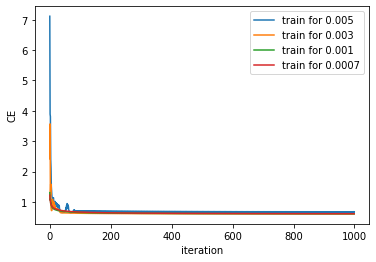

In [ ]:
learning_rates = [0.005, 0.003, 0.001, 0.0007]

plt.clf()
for learning_rate in learning_rates:
  multiClass_model = Multinomial_logistic(X_train_news.shape[1],y_train_news.shape[1]) 
  multiClass_model.W = np.array(multiClass_model.W, dtype = np.float128)
  ce_train, _ = multiClass_model.fit(X_train_news, y_train_news, X_valid_news, y_valid_news, niter=1000, lr=learning_rate, early_stop=True)
  plt.plot(ce_train/X_train_news.shape[0], label=f'train for {learning_rate}')

plt.xlabel("iteration")
plt.ylabel("CE")
plt.legend()

plt.savefig("mr_convergence_graph.png", bbox_inches="tight", dpi=300)
plt.show()

In [ ]:
plt.savefig("mr_convergence_graph.png", dpi=300)

<Figure size 432x288 with 0 Axes>

### HeatMap 

In [ ]:
print([f"{i}: {name}" for i, name in enumerate(train_dataset.target_names)]) 

['0: comp.graphics', '1: rec.sport.hockey', '2: sci.med', '3: soc.religion.christian']


In [ ]:
#selecting top 5 features from each category
words_5 = getBagWords(train_dataset, 5)
words_5 = np.array(words_5).flatten()
count_5 = CountVectorizer(vocabulary=words_5)
X_train_count_5 = count_5.fit_transform(train_dataset.data)
y_train_count_5 = LabelBinarizer().fit_transform(train_dataset.target)
X_train_count_5 = X_train_count_5.toarray()
X_train_count_5 = np.array(X_train_count_5, dtype = np.float128)

Most important words per category:
{'comp.graphics': array(['file', 'files', 'who', 'he', 'graphics'], dtype=object),
 'rec.sport.hockey': array(['nhl', 'season', 'hockey', 'game', 'team'], dtype=object),
 'sci.med': array(['n3jxp', 'chastity', 'geb', 'gordon', 'banks'], dtype=object),
 'soc.religion.christian': array(['christians', 'bible', 'christ', 'jesus', 'god'], dtype=object)}


In [ ]:
model_5 = Multinomial_logistic(nFeatures=X_train_count_5.shape[1], nClasses=y_train_count_5.shape[1]) 
model_5.fit(X_train_count_5, y_train_count_5)

(array([2542.80082713, 2379.78079447, 2301.25275524, 2249.59150492,
        2210.8824781 , 2179.61396772, 2153.48096074, 2131.18846815,
        2111.88444365, 2094.96659089, 2079.9908635 , 2066.62053713,
        2054.59477717, 2043.70798573, 2033.7956738 , 2024.72451544,
        2016.38518591, 2008.6871064 , 2001.55452406, 1994.92354538,
        1988.73986125, 1982.95698183, 1977.53485165, 1972.43875239,
        1967.6384253 , 1963.10736334, 1958.82223568, 1954.76241629,
        1950.90959514, 1947.24745549, 1943.76140435, 1940.43834614,
        1937.26649156, 1934.23519544, 1931.33481843, 1928.55660862,
        1925.89259967, 1923.33552289, 1920.87873101, 1918.51613189,
        1916.24213062, 1914.05157887, 1911.93973035, 1909.90220159,
        1907.93493726, 1906.03417952, 1904.19644068, 1902.41847896,
        1900.69727678, 1899.0300214 , 1897.4140875 , 1895.84702157,
        1894.32652785, 1892.85045562, 1891.41678778, 1890.02363041,
        1888.66920339, 1887.35183183, 1886.06993

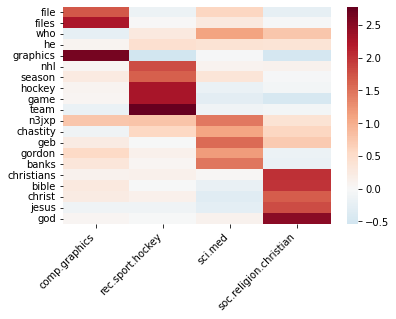

In [ ]:
from seaborn import heatmap
W_hat = model_5.W
y_axis_labels = words_5
x_axis_labels = ['comp.graphics', 'rec.sport.hockey', 'sci.med', 'soc.religion.christian']
hmp = heatmap(W_hat, cmap='RdBu_r', center=0, xticklabels = x_axis_labels, yticklabels=y_axis_labels)
hmp.set_xticklabels(hmp.get_xticklabels(), rotation=45, horizontalalignment='right')
fig = hmp.get_figure()
fig.savefig("heatmap1.png", bbox_inches='tight')

### Accuracy as a function of data set size

In [ ]:
from sklearn.model_selection import train_test_split
accuracies_MR = []
accuracies_KNN = []

SIZES =  [0.2, 0.4, 0.6, 0.8, 1.0]
N = X_train_n.shape[0]

# For different sizes of training set, record the accuracy on the held out test set
for train_size in SIZES:
    test_size = 1.0 - train_size
    print(f"--Models with N = {int(N*train_size)} observations")
    
    # Sub sample the training set
    if test_size != 0:
      trainX, _, trainY, _ = train_test_split(X_train_n, y_train_n, test_size=test_size, random_state=0)
    else:
      trainX, trainY = X_train_n, y_train_n

    # Logistic regression
    multiClass_model = Multinomial_logistic(trainX.shape[1],trainY.shape[1]) 
    trainX = np.array(trainX, dtype = np.float128)
    multiClass_model.W = np.array(multiClass_model.W, dtype = np.float128)
    
    mcl, _ = multiClass_model.fit(trainX, trainY, niter=1000)

    test_accuracy = evaluate(multiClass_model.predict(X_test_news), y_test_news)
    print("Done fitting MR")
    accuracies_MR.append(test_accuracy)

    # KNN
    KNN_model = KNeighborsClassifier(n_neighbors=3)
    KNN_model.fit(trainX, trainY)
    knn_predY = KNN_model.predict(X_test_news)
    knn_accuracy = accuracy_score(knn_predY, y_test_news)
    print("Done fitting KNN")
    accuracies_KNN.append(knn_accuracy)

Now plotting Accuracy as a function of training set size


<Figure size 432x288 with 0 Axes>

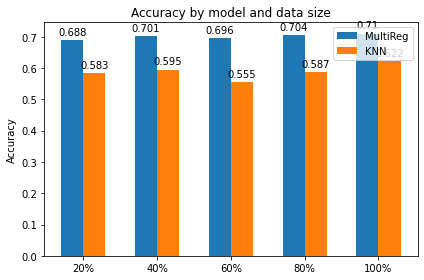

<Figure size 576x576 with 0 Axes>

In [ ]:
print("Now plotting Accuracy as a function of training set size")

# Plot Accuracy as function of training set size
plt.clf()

labels = ['20%', '40%', '60%', '80%', '100%']
x_axis = np.arange(len(labels))
bar_width = 0.30

fig, ax = plt.subplots()
plt.figure(figsize=(8,8))
mr_bars = ax.bar(x_axis - bar_width/2, accuracies_MR, bar_width, label='MultiReg')
knn_bars = ax.bar(x_axis + bar_width/2, accuracies_KNN, bar_width, label='KNN')

# Text for labels, title and custom x-axis labels

ax.set_ylabel('Accuracy')
ax.set_title('Accuracy by model and data size')
ax.set_xticks(x_axis)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = round(rect.get_height(),3)
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(mr_bars)
autolabel(knn_bars)

fig.tight_layout()
fig.savefig("multi-class-bar.png")
plt.show()

#code to download all saved graphs

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#!zip -r /content/file.zip /Graphs/

  adding: Graphs/ (stored 0%)
  adding: Graphs/Most positive weights.png (deflated 23%)
  adding: Graphs/mr_convergence_graph.png (deflated 97%)
  adding: Graphs/.ipynb_checkpoints/ (stored 0%)
  adding: Graphs/Most Negative.png (deflated 25%)
  adding: Graphs/Most Positive.png (deflated 25%)
  adding: Graphs/LR_monitor_CE.png (deflated 16%)
  adding: Graphs/training_ce.png (deflated 19%)
  adding: Graphs/multi-class-bar.png (deflated 12%)
  adding: Graphs/AUROC_by_data_size.png (deflated 17%)
  adding: Graphs/ROC_curves.png (deflated 10%)
  adding: Graphs/Accuracy_by_data_size_binary.png (deflated 98%)
  adding: Graphs/Most negative weights.png (deflated 23%)
  adding: Graphs/heatmap1.png (deflated 8%)


In [ ]:
#from google.colab import files
#files.download("/content/file.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>